Train shape: (1149, 8)
Date range: 2020-08-03 00:00:00 -> 2025-03-10 00:00:00
        time  close    target
0 2020-08-03  19.63  2.977059
1 2020-08-04  19.91  2.991222
2 2020-08-05  20.10  3.000720
3 2020-08-06  20.01  2.996232
4 2020-08-07  20.14  3.002708
Dataset size: 1113 samples
Sample shapes: x=torch.Size([32]), y=torch.Size([5])
DLinearModel(
  (decomp): SeriesDecomp(
    (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(12,))
  )
  (linear_seasonal): Linear(in_features=32, out_features=5, bias=True)
  (linear_trend): Linear(in_features=32, out_features=5, bias=True)
)
Epoch 001  train_loss = 22.606642
Epoch 005  train_loss = 0.097934
Epoch 010  train_loss = 0.003878
Epoch 015  train_loss = 0.003857
Epoch 020  train_loss = 0.003838
Epoch 025  train_loss = 0.003819
Epoch 030  train_loss = 0.003800
Epoch 035  train_loss = 0.003787
Epoch 040  train_loss = 0.003767
Epoch 045  train_loss = 0.003753
Epoch 050  train_loss = 0.003740
Training done.


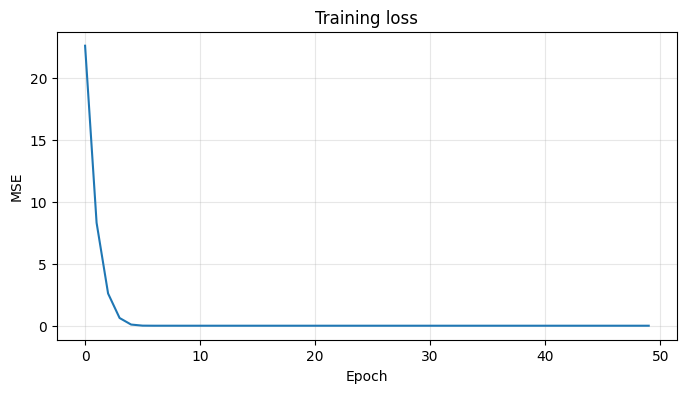

Prediction preview: [129.13014221 129.52130127 128.30204773 136.38061523 125.09505463
 131.58023071 130.06878662 130.57929993 135.34646606 128.60881042]


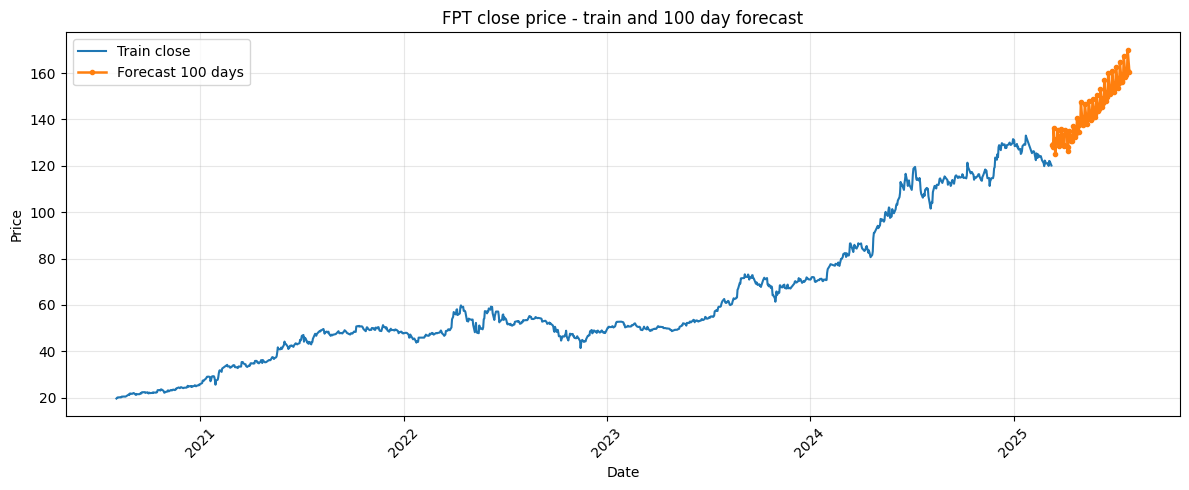

Saved submission file to: submission.csv
   id       close
0   1  129.130142
1   2  129.521301
2   3  128.302048
3   4  136.380615
4   5  125.095055


In [1]:
# ============================================================
# AIO 2025 - LTSF Linear Forecasting Challenge
# Linear / NLinear / DLinear baseline (PyTorch)
# ============================================================

import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -----------------------
# 1. Config
# -----------------------
CONFIG = {
    "seed": 42,
    "input_len": 32,          # N - số ngày quan sát
    "output_len": 5,          # M - số ngày dự báo mỗi bước recursive
    "total_pred_days": 100,   # phải là 100 theo đề bài
    "batch_size": 64,
    "num_epochs": 50,
    "lr": 1e-3,
    "model_type": "dlinear",  # "linear", "nlinear", "dlinear"
    "log_transform": True,    # dùng log(close) như baseline
}


# -----------------------
# 2. Utils
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def find_data_path(filename: str) -> Path:
    """Tự tìm file trong môi trường Kaggle hoặc local."""
    candidates = [
        Path("/kaggle/input/aio-2025-linear-forecasting-challenge") / filename,
        Path("../input/aio-2025-linear-forecasting-challenge") / filename,
        Path("./") / filename,
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Cannot find {filename} in known locations")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(CONFIG["seed"])


# -----------------------
# 3. Load data
# -----------------------
train_path = find_data_path("FPT_train.csv")
df = pd.read_csv(train_path)

df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

if CONFIG["log_transform"]:
    df["target"] = np.log(df["close"].values.astype("float32"))
else:
    df["target"] = df["close"].astype("float32")

print("Train shape:", df.shape)
print("Date range:", df["time"].min(), "->", df["time"].max())
print(df[["time", "close", "target"]].head())


# -----------------------
# 4. Dataset
# -----------------------
class TimeSeriesDataset(Dataset):
    """
    Sliding window dataset.
    Input:  target[t : t+input_len]
    Label:  target[t+input_len : t+input_len+output_len]
    """

    def __init__(self, series, input_len: int, output_len: int):
        self.series = np.asarray(series, dtype=np.float32)
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.series) - self.input_len - self.output_len + 1

    def __getitem__(self, idx: int):
        x = self.series[idx : idx + self.input_len]
        y = self.series[
            idx + self.input_len : idx + self.input_len + self.output_len
        ]
        return torch.from_numpy(x), torch.from_numpy(y)


# Chuỗi 1 chiều close_log
series = df["target"].values
INPUT_LEN = CONFIG["input_len"]
OUTPUT_LEN = CONFIG["output_len"]

dataset = TimeSeriesDataset(series, INPUT_LEN, OUTPUT_LEN)
train_loader = DataLoader(
    dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    drop_last=False,
)

print(f"Dataset size: {len(dataset)} samples")
print(f"Sample shapes: x={dataset[0][0].shape}, y={dataset[0][1].shape}")


# -----------------------
# 5. Model definitions
# -----------------------
class LinearModel(nn.Module):
    def __init__(self, input_len: int, output_len: int):
        super().__init__()
        self.linear = nn.Linear(input_len, output_len)

    def forward(self, x):
        # x: [batch, input_len]
        return self.linear(x)


class NLinearModel(nn.Module):
    """
    NLinear trong các paper LTSF:
    - Lấy toàn bộ input trừ đi giá trị cuối cùng
    - Mô hình học trên phần đã chuẩn hóa
    - Output cộng lại giá trị cuối làm "level"
    """

    def __init__(self, input_len: int, output_len: int):
        super().__init__()
        self.linear = nn.Linear(input_len, output_len)

    def forward(self, x):
        # x: [batch, input_len]
        last = x[:, -1:].detach()       # [batch, 1]
        x_norm = x - last               # chuẩn hóa quanh điểm cuối
        out = self.linear(x_norm) + last
        return out


class SeriesDecomp(nn.Module):
    """Moving average decomposition: x = seasonal + trend."""

    def __init__(self, kernel_size: int):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.avg = nn.AvgPool1d(
            kernel_size=kernel_size, stride=1, padding=padding
        )

    def forward(self, x):
        # x: [batch, T]
        x_t = x.unsqueeze(1)           # [batch, 1, T]
        trend = self.avg(x_t).squeeze(1)
        seasonal = x - trend
        return seasonal, trend


class DLinearModel(nn.Module):
    """
    DLinear:
      - Decompose chuỗi thành seasonal và trend
      - Hai nhánh linear riêng, sau đó cộng lại
    """

    def __init__(self, input_len: int, output_len: int, kernel_size: int = 25):
        super().__init__()
        self.decomp = SeriesDecomp(kernel_size)
        self.linear_seasonal = nn.Linear(input_len, output_len)
        self.linear_trend = nn.Linear(input_len, output_len)

    def forward(self, x):
        # x: [batch, input_len]
        seasonal, trend = self.decomp(x)
        out_s = self.linear_seasonal(seasonal)
        out_t = self.linear_trend(trend)
        return out_s + out_t


def build_model(model_type: str, input_len: int, output_len: int) -> nn.Module:
    model_type = model_type.lower()
    if model_type == "linear":
        return LinearModel(input_len, output_len)
    if model_type == "nlinear":
        return NLinearModel(input_len, output_len)
    if model_type == "dlinear":
        return DLinearModel(input_len, output_len)
    raise ValueError(f"Unknown model_type: {model_type}")


model = build_model(CONFIG["model_type"], INPUT_LEN, OUTPUT_LEN).to(device)
print(model)


# -----------------------
# 6. Train loop
# -----------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])

num_epochs = CONFIG["num_epochs"]
train_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(dataset)
    train_losses.append(epoch_loss)

    if epoch % 5 == 0 or epoch == 1 or epoch == num_epochs:
        print(f"Epoch {epoch:03d}  train_loss = {epoch_loss:.6f}")

print("Training done.")

# Optional: vẽ loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)
plt.show()


# -----------------------
# 7. Recursive forecasting 100 ngày
# -----------------------
def recursive_forecast(model, last_input, total_pred_days, output_len, device):
    """
    model: đã train, nhận input shape [batch, input_len]
    last_input: numpy 1d, length = input_len
    return: numpy 1d, length = total_pred_days
    """
    model.eval()
    current = last_input.astype(np.float32).copy()
    preds = []
    remaining = total_pred_days

    with torch.no_grad():
        while remaining > 0:
            step = min(output_len, remaining)
            x = torch.from_numpy(current).unsqueeze(0).to(device)
            out = model(x).squeeze(0).cpu().numpy()  # [output_len]
            preds.extend(out[:step])
            # trượt cửa sổ: bỏ step phần đầu, thêm step prediction
            current = np.concatenate([current[step:], out[:step]])
            remaining -= step

    return np.array(preds, dtype=np.float32)


last_input = series[-INPUT_LEN:]
preds_log = recursive_forecast(
    model=model,
    last_input=last_input,
    total_pred_days=CONFIG["total_pred_days"],
    output_len=OUTPUT_LEN,
    device=device,
)

assert len(preds_log) == CONFIG["total_pred_days"]

if CONFIG["log_transform"]:
    preds_close = np.exp(preds_log)
else:
    preds_close = preds_log

# Đảm bảo là float
preds_close = preds_close.astype("float64")

print("Prediction preview:", preds_close[:10])


# -----------------------
# 8. Visualization: nối train + forecast
# -----------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(df["time"], df["close"], label="Train close", linewidth=1.5)

last_date = df["time"].iloc[-1]
future_idx = np.arange(1, CONFIG["total_pred_days"] + 1)
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=CONFIG["total_pred_days"],
    freq="B",  # business day, cho đẹp chart, không ảnh hưởng submission
)

ax.plot(
    future_dates,
    preds_close,
    label="Forecast 100 days",
    linewidth=1.8,
    marker="o",
    markersize=3,
)

ax.set_title("FPT close price - train and 100 day forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True, alpha=0.3)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -----------------------
# 9. Tạo submission.csv
# -----------------------
submission = pd.DataFrame(
    {
        "id": np.arange(1, CONFIG["total_pred_days"] + 1),
        "close": preds_close,
    }
)

submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved submission file to:", submission_path)
print(submission.head())
